# Info

Этапы:
1. [Детекция страницы пасспорта с фото](#page-detection)
1. [Детекция трех текстовых областей в определенной области страницы](#text-detection)
1. [Распознавание символов в текстовых областях](#ocr)
    1. [С помощью библиотеки](#ocr-tesseract) (pytesseract)
    1. [С помощью API](#ocr-ocrspace) (ocrspace)
    1. [С помощью собственного алгоритма](#ocr-cnn) (tensorflow)
    1. [Результаты](#ocr-results)
    1. [Возможные улучшения](#ocr-improvements)

Инструкция для выполнения в Google Colab:
1. При первом запуске, после выполнения ячейки `!pip install pytesseract` перезапустить среду выполнения (*Runtime → Restart and run all*, на вопрос с подтверждением ответить *Yes*).
1. В разделе Settings выбрать файл для распознавания и выполнить *Run after* (CTRL+F10).

Требования к сканам паспортов:
1. Высота изображения = высоте разворота (2 страницы пасспорта).
1. Без поворота (горизонтальный текст).
1. Без перспективных искажений.

In [1]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Settings

In [2]:
INPUT_IMAGE = 'passport-scans/1.jpeg' #@param ['passport-scans/0.jpeg', 'passport-scans/1.jpeg', 'passport-scans/2.jpeg', 'passport-scans/3.jpeg', 'passport-scans/4.png', 'passport-scans/5.jpeg', 'passport-scans/6.jpeg', 'passport-scans/7.jpeg', 'passport-scans/8.jpeg', 'passport-scans/9.jpeg'] {allow-input: true}

In [3]:
#@title { form-width: "1px", display-mode: "form" }
#@markdown Page detector configuration
class PageDetectorConfig:

    """ Parameters for region proposal stage. """
    # Rescale images before performing selective search. Large scale -> more recall but less speed.
    RP_SCALE = 0.2
    
    # (lower, upper) bounds for rectangle around bottom page of the passport.
    # Wider range -> more recall but also more chances to get wrong region.
    RP_ASPECT = (1.4, 1.5)
    RP_WIDTH_PX = (300, None)
    RP_HEIGHT_PX = (160, None)
    
    """ Parameters for face detector. """
    # For all available options see: `os.listdir(cv2.data.haarcascades)`
    HAAR_FACE_DETECTION_MODEL = 'haarcascade_frontalface_alt.xml'
    
    """ Name area crop. """
    # Coordinates of area with full name info relative to page size.
    NAME_AREA_RIGHT_PCT = 0.1
    NAME_AREA_TOP_PCT = 0.05
    NAME_AREA_WIDTH_PCT = 0.5
    NAME_AREA_HEIGHT_PCT = 0.4
    
    # Resize all name area crops to single size (px).
    NAME_AREA_WIDTH_PX = 240
    NAME_AREA_HEIGHT_PX = 130


# Init

## Libraries

In [4]:
_gdown_version = !gdown -V
if tuple(map(int, _gdown_version.s.split()[1].split('.'))) < (4, 5, 4):
    !pip install -q --upgrade --no-cache-dir gdown

In [5]:
!sudo apt-get -qq install tesseract-ocr-rus > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [6]:
!pip install -q ocrspace

## Downloads

In [7]:
!test -f passport-scans.zip || gdown -O passport-scans.zip 1zDC87vdMl_jZCzj_UW6hTe2SxlEA9hEM
!test -d passport-scans || unzip -q passport-scans

!test -f ocr-models.zip || gdown -O ocr-models.zip 1b4pon8-m90vmXV6c3OWJVqqEXJJrmGwZ
!test -d ocr-models || unzip -q ocr-models

Downloading...
From: https://drive.google.com/uc?id=1zDC87vdMl_jZCzj_UW6hTe2SxlEA9hEM
To: /content/passport-scans.zip
100% 2.98M/2.98M [00:00<00:00, 205MB/s]
Downloading...
From: https://drive.google.com/uc?id=1b4pon8-m90vmXV6c3OWJVqqEXJJrmGwZ
To: /content/ocr-models.zip
100% 198M/198M [00:01<00:00, 108MB/s] 


## Imports

In [8]:
import time
import base64
import random
from pathlib import Path

import numpy as np
import pandas as pd

import cv2
import imutils
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf

import pytesseract
import ocrspace

## Definitions

In [9]:
#@title { form-width: "1px", display-mode: "form" }
#@markdown Constants
#@markdown ```python
#@markdown MODELS_CACHE
#@markdown ```
MODELS_CACHE = MODELS_CACHE if 'MODELS_CACHE' in globals() else []

In [10]:
#@title { form-width: "1px", display-mode: "form" }
#@markdown Utilities
#@markdown ```python
#@markdown def cvread(path)
#@markdown def make_crop(img, rect, target_size=None)
#@markdown def show(img, size=4, bgr=True)
#@markdown def draw_rect(img, rect, color=(0, 255, 0), thickness=2, inplace=False)
#@markdown def draw_rects(img, rects, color=None, inplace=False)
#@markdown def to_gray(img, ch=0)
#@markdown def sharpen(img, scale=1.0, method='antiblur', renormalize=True)
#@markdown ```
def cvread(path, width=None, height=None):
    """ Bug-fix for non-Unicode file names. """
    byte_arr = np.fromfile(path, dtype=np.uint8)
    img = cv2.imdecode(byte_arr, cv2.IMREAD_COLOR)
    return imutils.resize(img, width, height)


def make_crop(img, rect, target_size=None):
    x, y, w, h = rect
    x1 = max(0, x)
    x2 = max(0, x + w + 1)
    y1 = max(0, y)
    y2 = max(0, y + h + 1)
    arr = img[y1 : y2, x1 : x2]
    if target_size is not None:
        tx, ty = target_size
        arr = cv2.resize(arr, (tx, ty))
    return arr


def show(img, size=4, bgr=True):
    plt.figure(figsize=(size, size))
    if len(img.shape) == 3:
        plt.imshow(img[..., ::-1] if bgr else img)
    else:
        plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.box()
    print(img.shape)


def draw_rect(img, rect, color=(0, 255, 0), thickness=2, inplace=False):
    if not inplace:
        img = img.copy()
    x, y, w, h = rect
    cv2.rectangle(img, (x, y), (x + w, y + h), color, thickness)
    return img


def draw_rects(img, rects, color=None, inplace=False):
    if not inplace:
        img = img.copy()
        
    for (x, y, w, h) in rects:
        c = color if color is not None else [random.randint(0, 255) for j in range(0, 3)]
        cv2.rectangle(img, (x, y), (x + w, y + h), c, 2)
        
    return img


def to_gray(img, ch=0):
    if img.ndim > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if ch:
        img = np.stack([img] * ch, axis=-1)
    return img


def sharpen(img, scale=1.0, method='antiblur', renormalize=True):
    # Based on https://stackoverflow.com/a/40039487/7204581
    if method == 'antiblur':
        img = cv2.addWeighted(img, 4 * scale, cv2.blur(img, (30, 30)), -4 * scale, 0)
    elif method == 'filter':
        kernel = np.array([[-1,-1,-1], [-1, 9,-1], [-1,-1,-1]]) * scale
        img = cv2.filter2D(img, -1, kernel)
    else:
        raise ValueError(f'Valid methods are "antiblur", "filter", got: "{method}"')
    if renormalize and img.dtype.kind == 'f':
        img = img.clip(0, 1)
    return img

In [11]:
#@title { form-width: "1px", display-mode: "form" }
#@markdown Page detector
#@markdown ```python
#@markdown def detect_page(img, face_detector, config)
#@markdown def get_names_area_rect(page_rect, config)
#@markdown ```

##################
# Region proposal
#################

def search_roi(img, scale=1.0):
    if scale != 1.0:
        img = imutils.resize(img, height=round(img.shape[0] * scale))
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    if scale != 1.0:
        rects = (rects / scale).round().astype(rects.dtype)
    return rects


def filter_roi(rects, aspect=(None, None), width_px=(None, None), height_px=(None, None)):
    mask = np.ones(len(rects)).astype(bool)
    
    w, h = rects[:, 2], rects[:, 3]
    a = w / h
    
    mask &= (aspect[0] is None) or (aspect[0] <= a)
    mask &= (aspect[1] is None) or (a <= aspect[1])
    
    mask &= (width_px[0] is None) or (width_px[0] <= w)
    mask &= (width_px[1] is None) or (w <= width_px[1])
    
    mask &= (height_px[0] is None) or (height_px[0] <= h)
    mask &= (height_px[1] is None) or (h <= height_px[1])
    
    return rects[mask]


def get_roi_rects(img, config):
    rects_all = search_roi(img, scale=config.RP_SCALE)
    rects = filter_roi(rects_all, aspect=config.RP_ASPECT,
                       width_px=config.RP_WIDTH_PX,
                       height_px=config.RP_HEIGHT_PX)
    return rects

################
# Face detector
###############

def get_face_rects(img, face_detector, config):
    dets = face_detector.detectMultiScale(
        img,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE,
    )
    return dets


def assert_single_face(dets):
    if len(dets) < 1:
        raise ValueError(f'Passport photo was not found')
    if len(dets) > 1:
        raise ValueError(f'More then 1 passport photo were detected')

################
# Page detector
###############

def get_expected_face_coords(page_rects, margin_left_pct=0.73, margin_top_pct=0.31):
    px, py, pw, ph = page_rects.T
    return np.c_[px + pw - pw * margin_left_pct, py + ph * margin_top_pct]
    
    
def get_face_coords(face_rect):
    fx, fy, fw, fh = face_rect
    return np.r_[fx + fw, fy]
    
    
def face_displacement(face_rect, page_rects):
    expected_face_coords = get_expected_face_coords(page_rects)
    actual_face_coords = get_face_coords(face_rect)
    
    dist = np.linalg.norm(expected_face_coords - actual_face_coords, axis=1)
    return dist


def closest_page_rect(face_rect, page_rects):
    dist = face_displacement(face_rect, page_rects)
    return page_rects[dist.argmin()]


def detect_page(img, face_detector, config):
    # Detect face
    dets = get_face_rects(img, face_detector, config)
    assert_single_face(dets)
    face_rect = dets[0]
    
    # Region proposals
    roi_rects = get_roi_rects(img, config)
    
    # Select best region
    page_rect = closest_page_rect(face_rect, roi_rects)
    
    return page_rect


def get_names_area_rect(page_rect, config):
    """ Given page rectangle calculate coordinates of the text
        region with a surname, name and patronymic.
    """
    x, y, w, h = page_rect
    aw = w * config.NAME_AREA_WIDTH_PCT  # 0.5
    ah = h * config.NAME_AREA_HEIGHT_PCT  # 0.4
    x1 = x + w - aw - w * config.NAME_AREA_RIGHT_PCT  # 0.1
    y1 = y + h * config.NAME_AREA_TOP_PCT  # 0.05
    return np.array([x1, y1, aw, ah]).round().astype(int)

In [12]:
#@title { form-width: "1px", display-mode: "form" }
#@markdown Text detector
#@markdown ```python
#@markdown def get_text_treshold(img)
#@markdown def get_contours(thresh, min_aspect=2, max_aspect=15, min_rel_height=.06, top_central=3)
#@markdown def get_text_rects(img)
#@markdown ```

# https://pyimagesearch.com/2015/11/30/detecting-machine-readable-zones-in-passport-images/
def get_text_treshold(img):
    img = cv2.normalize(img,  None, 0, 255, cv2.NORM_MINMAX)

    gray = to_gray(img)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

    gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")
    gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
    thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
    return thresh


def get_contours_center(cnts):
    """ Central point of contours cluster. """
    cluster = np.concatenate(cnts)
    (cx, cy, cw, ch) = cv2.boundingRect(cluster)
    return np.array([cx + cw / 2, cy + ch / 2])


def get_contours(thresh, min_aspect=2, max_aspect=15, min_rel_height=.06, top_central=3):
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    center = get_contours_center(cnts)
    
    out = []
    dist_to_center = []
    for contour in cnts:
        (x, y, w, h) = cv2.boundingRect(contour)
        aspect = w / h
        rel_height = h / thresh.shape[0]
        if (aspect < min_aspect) or (max_aspect < aspect) or (rel_height < min_rel_height):
            continue
            
        if top_central is not None:
            cnt_center = np.array([x + w / 2, y + h / 2])
            dist_to_center.append(np.linalg.norm(center - cnt_center))
        
        out.append(contour)
        
    if top_central is not None:
        idxs = np.argsort(dist_to_center)[:top_central]
        out = [out[i] for i in idxs]
    return out


def to_rects(cnts):
    """
    Return (x, y, w, h) of bounding box for each contour. To extract
    countours use `cnts = cv2.findContours()` with `imutils.grab_contours(cnts)`.
    """
    out = np.array([cv2.boundingRect(c) for c in cnts])
    return out


def expand_rects(rects, expand=(0, 0, 0, 0)):
    """
    rects: 2d array, list of tuples
        List of rectangles in form of (x, y, w, h). Or array with shape (n, 4).
    expand: int, (int, int, int, int)
        Increase rectangle are by n pixels into four directions (top, right,
        bottom, left).

    >>> expand_rects([[0, 0, 0, 0]], expand=(2, 10, 20, 1))
    array([[-1, -2, 11, 22]])
    """
    rects = np.asarray(rects)
    if type(expand) is int:
        expand = (expand,) * 4
    (top, right, bottom, left) = expand
    return rects + [-left, -top, left + right, top + bottom]


def get_text_rects(img):
    thresh = get_text_treshold(img)
    cnts = get_contours(thresh)
    rects = to_rects(cnts)
    y_coord = rects[:, 1]
    return rects[y_coord.argsort()]

In [13]:
#@title { form-width: "1px", display-mode: "form" }
#@markdown Text image preprocessing
#@markdown ```python
#@markdown def preprocess_text_img_ocr(img, target_height=64, apply_sharpen=True, invert_color=False)
#@markdown def preprocess_text_img_cnn(img, target_size=(160, 16))
#@markdown def image_to_base64_content(img)
#@markdown def make_batch(imgs)
#@markdown ```

def preprocess_text_img_ocr(img, target_height=64, apply_sharpen=True, invert_color=False):
    img = 255 - to_gray(img)

    img = cv2.normalize(img,  None, 0, 255, cv2.NORM_MINMAX)

    # Add paddings
    h, w = img.shape
    
    blank = np.zeros((round(h * 1.5), round(w * 1.5)), dtype=np.uint8)
    th, tw = blank.shape

    x, y = (tw - w) // 2, (th - h) // 2
    blank[y : y + h, x : x + w] = img
    img = blank
    img = imutils.resize(img, height=target_height, inter=cv2.INTER_CUBIC)

    if apply_sharpen:
        img = sharpen(img)
    if not invert_color:
        img = 255 - img
    return img


def preprocess_text_img_cnn(img, target_size=(160, 16)):
    # 1. Gray scale
    # 2. Invert (bg=black, text=white)
    img = 255 - to_gray(img)

    # 3. Normalize (bg=0, text=255)
    img = cv2.normalize(img,  None, 0, 255, cv2.NORM_MINMAX)

    # 4. Resize to CNN input
    tw, th = target_size
    img = cv2.resize(img, (round(img.shape[1]*.9), 12))
    # font size should be 12px or less
    h, w = img.shape

    if w > tw:
        # Cut from right if too large
        img = img[:, :tw]
        w = tw
    
    # Pad left and right
    blank = np.zeros((th, tw), dtype=np.uint8)
    x, y = (tw - w) // 2, (th - h) // 2
    blank[y : y + h, x : x + w] = img
    img = blank
    
    # 5. Rescale from 0.0 to 1.0
    return img / 255


def image_to_base64_content(img):
    retval, buffer = cv2.imencode('.png', img)
    base64_image_content = base64.b64encode(buffer).decode()
    return 'data:image/png;base64,' + base64_image_content


def make_batch(imgs):
    return np.array(imgs)[..., None]

In [14]:
#@title { form-width: "1px", display-mode: "form" }
#@markdown OCR class
#@markdown ```python
#@markdown class OCR(models_dir)
#@markdown ```

class OCR:
    MODEL_CHAR_NAMES = [
        'model_char0',   #  0
        'model_char1',   #  1
        'model_char2',   #  2
        'model_char3',   #  3
        'model_char4',   #  4
        'model_char5',   #  5
        'model_char6',   #  6
        'model_char-6',  #  7
        'model_char-5',  #  8
        'model_char-4',  #  9
        'model_char-3',  # 10
        'model_char-2',  # 11
        'model_char-1',  # 12
    ]
    MODEL_TEXT_LEN_NAME = 'model_text_len'
    PREDICT_STRATEGY = {
        # Text len : [model index]
         1: [0],
         2: [0, 1],
         3: [0, 1, 2],
         4: [0, 1, 2, 3],
         5: [0, 1, 2, 3, 4],
         6: [0, 1, 2, 10, 11, 12],
         7: [0, 1, 2, 3, 10, 11, 12],
         8: [0, 1, 2, 3, 9, 10, 11, 12],
         9: [0, 1, 2, 3, 8, 9, 10, 11, 12],
        10: [0, 1, 2, 3, 4, 8, 9, 10, 11, 12],
        11: [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12],
        12: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12],
        13: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    }
    CLASS_NAMES = '-АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯ'

    def __init__(self, models_dir):
        global MODELS_CACHE

        self.models_dir = Path(models_dir)

        self.model_text_len = self.load_model_text_len()
        
        if MODELS_CACHE == []:
            MODELS_CACHE = self.load_models_char()
        self.models_char = MODELS_CACHE

        self.chars = np.array(list(self.CLASS_NAMES))

    def load_model_text_len(self):
        return tf.keras.models.load_model(self.models_dir /
                                                         self.MODEL_TEXT_LEN_NAME)
        
    def load_models_char(self):
        return [tf.keras.models.load_model(self.models_dir / model_name)
                       for model_name in self.MODEL_CHAR_NAMES]

    def decode_text_len(self, preds):
        return np.argmax(preds, axis=1) + 4


    def get_text_len(self, batch):
        preds = self.model_text_len(batch)
        return self.decode_text_len(preds)


    def get_char_preds(self, model_id, batch):
        preds = self.models_char[model_id](batch)
        char_ids = np.argmax(preds, axis=1)
        return self.chars[char_ids]


    def predict_text(self, batch, debug=False):
        text_lens = self.get_text_len(batch)
        models_output_cache = np.full((batch.shape[0], 13), '?')

        selected_models_ids = []
        if debug:
            selected_models_ids = list(range(13))
        else:
            for text_len in set(text_lens):
                selected_models_ids.extend(self.PREDICT_STRATEGY[text_len])
            selected_models_ids = list(set(selected_models_ids))

        for model_id in selected_models_ids:
            char_preds = self.get_char_preds(model_id, batch)  # len=len(batch)
            models_output_cache[:, model_id] = char_preds

        out = []
        for i, text_len in enumerate(text_lens):
            chars = models_output_cache[i, self.PREDICT_STRATEGY[text_len]]
            out.append(''.join(chars))

        if debug:
            print(models_output_cache)
        return out

In [15]:
page_cfg = PageDetectorConfig()

haar_model_path = cv2.data.haarcascades + page_cfg.HAAR_FACE_DETECTION_MODEL
face_detector = cv2.CascadeClassifier(haar_model_path)

# https://ocr.space/OCRAPI#PostParameters
api = ocrspace.API(language=ocrspace.Language.Russian, scale=True)

ocr = OCR('ocr-models')

ocr_results = []

# Main

## Read data

(640, 445, 3)


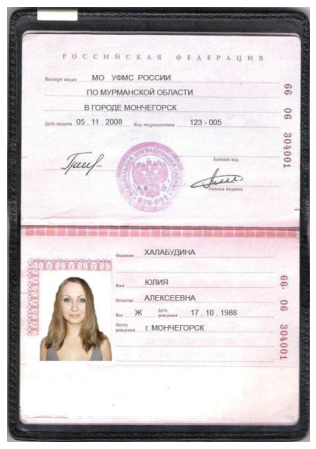

In [16]:
img = cvread(INPUT_IMAGE, height=640)
show(img, size=8)

<a id="page-detection"></a>
## Этап 1. Детекция страницы

(276, 406, 3)


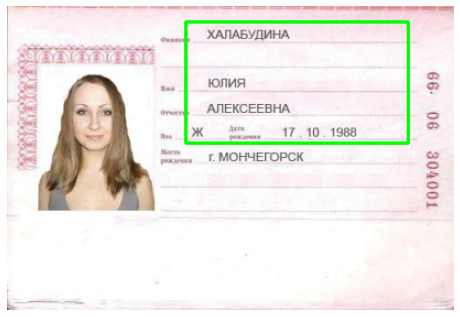

In [17]:
page_rect = detect_page(img, face_detector, page_cfg)
names_rect = get_names_area_rect((0, 0, page_rect[2], page_rect[3]), page_cfg)

page_crop = make_crop(img, page_rect)
show(draw_rect(page_crop, names_rect), 8)

<a id="text-detection"></a>
## Этап 2. Детекция текстовых областей

(130, 720, 3)


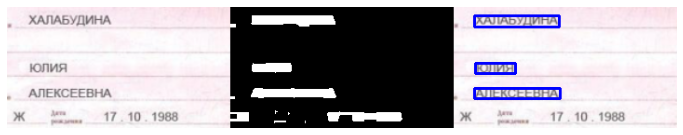

In [18]:
names_rect = get_names_area_rect(page_rect, page_cfg)
crop = make_crop(img, names_rect,
    target_size=(page_cfg.NAME_AREA_WIDTH_PX, page_cfg.NAME_AREA_HEIGHT_PX))

thresh = get_text_treshold(crop)
text_rects = get_text_rects(crop)

text_rects_1 = expand_rects(text_rects, 1)
text_crops = [make_crop(crop, rect) for rect in text_rects_1]

show(np.hstack((
    crop,
    to_gray(thresh, ch=3),
    draw_rects(crop, text_rects, color=255),
)), size=12)


<a id="ocr"></a>
## Этап 3. Распознавание символов

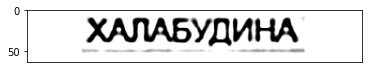

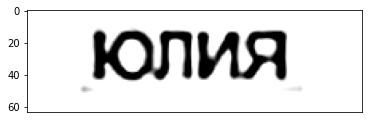

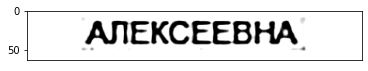

In [19]:
ocr_imgs = [preprocess_text_img_ocr(crop) for crop in text_crops]
for ocr_img in ocr_imgs:
    plt.imshow(ocr_img, cmap='gray', vmin=0, vmax=255)
    plt.xticks([])
    plt.show()

<a id="ocr-tesseract"></a>
### Tesseract

In [20]:
results_tesseract = []
for ocr_img in ocr_imgs:
    string = pytesseract.image_to_string(Image.fromarray(ocr_img), lang='rus')
    string = string.strip()
    results_tesseract.append(string)
    print(string)

ХАЛАБУДИНА
ЮЛИЯ
АЛЕКСЕЕВНА.


<a id="ocr-ocrspace"></a>
### ocr.space API

In [21]:
results_ocrspace = []
for ocr_img in ocr_imgs:
    base64_img = image_to_base64_content(ocr_img)
    time.sleep(1)  # wait between calls to avoid IP ban
    string = api.ocr_base64(base64_img).strip()
    results_ocrspace.append(string)
    print(string)

ХАЛАБУДИНА
юлия
АЛЕКСЕЕВНА


<a id="ocr-cnn"></a>
### CNN

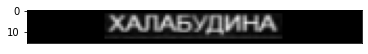

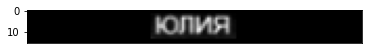

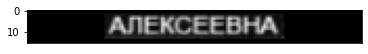

In [22]:
cnn_imgs = [preprocess_text_img_cnn(crop) for crop in text_crops]
for cnn_img in cnn_imgs:
    plt.imshow(cnn_img, cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.show()

In [23]:
results_cnn = ocr.predict_text(make_batch(cnn_imgs), debug=0)
set(map(print, results_cnn));

ХАИАВОДИНА
ЮЛИВ-
АЛЕКСЕЕВНА


<a id="ocr-results"></a>
### Результаты

(130, 240, 3)


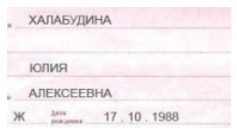

In [24]:
show(crop)

In [25]:
pd.DataFrame({
    'tesseract': results_tesseract,
    'ocr.space': results_ocrspace,
    'cnn': results_cnn,
},
    ['Фамилия', 'Имя', 'Отчество']
).T

,Фамилия,Имя,Отчество
tesseract,ХАЛАБУДИНА,ЮЛИЯ,АЛЕКСЕЕВНА.
ocr.space,ХАЛАБУДИНА,юлия,АЛЕКСЕЕВНА
cnn,ХАИАВОДИНА,ЮЛИВ-,АЛЕКСЕЕВНА


<a id="ocr-improvements"></a>
### Возможные улучшения
1. Улучшение генератора обучающих сэмплов:
    1. При генерации обучающих сэмплов использовать размытие (blur или GaussianBlur).
    1. Генерировать обучающие сэмплы на лету.
        - Учесть что генерация 200k сэмплов ~25мин., а одна эпоха 40 сек. на GPU.
        - Выход: отрендерить отдельные символы, компановать и аугментировать инпуты на GPU.
    1. Вместо случайных наборов букв найти список реальных ФИО.
1. Улучшение детектора:
    1. Исправление преспективных искажений.
    1. Исправление поворота.
1. Улучшения архитектуры нейросети:
    1. Сделать одну multi-output (multi-headed) модель с общими сверточными слоями.
    1. Попробовать другие архитектуры: CRNN (conv+RNN), ViT.



Пример из генератора обучающих сэмплов ([dataset-generator.ipynb](https://colab.research.google.com/drive/1gktzxa9XRhqr6oQeG93qajD2d0F8a_dz?usp=sharing)):

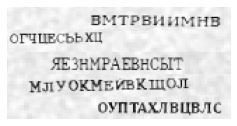